In [1]:
import calendar
import pandas as pd
import numpy as np
import io
import os
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random as rd # generating random numbers
import datetime # manipulating date formats
# Viz
import matplotlib.pyplot as plt # basic plotting
import seaborn as sns # for prettier plots
import scipy.stats as scs
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import mean_absolute_error
from matplotlib import pyplot
from pandas import read_csv
from matplotlib import pyplot
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import seaborn; seaborn.set()
import time
%matplotlib inline

## A. Weather Data

In [2]:
cols=['dt_iso','temp','pressure','humidity','wind_speed','rain_1h','clouds_all',
      'weather_main']#,'weather_description']
df_weather=pd.read_csv('/bigdata/tara/london_weather_2018.csv',usecols=cols)
df_weather.head()

,dt_iso,temp,pressure,humidity,wind_speed,rain_1h,clouds_all,weather_main
0,2018-01-01 00:00:00 +0000 UTC,280.27,996,70,9,NaN,68,Clouds
1,2018-01-01 01:00:00 +0000 UTC,280.01,997,70,9,0.3,20,Rain
2,2018-01-01 02:00:00 +0000 UTC,279.28,999,81,6,NaN,48,Clouds
3,2018-01-01 03:00:00 +0000 UTC,279.04,999,75,7,NaN,48,Drizzle
4,2018-01-01 04:00:00 +0000 UTC,278.81,999,70,6,0.3,48,Rain


In [3]:
df_weather[df_weather['dt_iso']=='2018-01-01 13:00:00 +0000 UTC']

,dt_iso,temp,pressure,humidity,wind_speed,rain_1h,clouds_all,weather_main
13,2018-01-01 13:00:00 +0000 UTC,279.87,995,81,4,0.3,24,Rain
14,2018-01-01 13:00:00 +0000 UTC,279.87,995,81,4,0.3,24,Drizzle


In [4]:
#df_weather[df_weather.duplicated('dt_iso')==True]

In [5]:
df_weather = df_weather.groupby('dt_iso').agg({'temp':'first', 'pressure':'first',  'wind_speed':'first',
                              'rain_1h':'first','weather_main': ','.join, 'humidity':'first',
                             'clouds_all':'first' }).reset_index()

In [6]:
df_weather=pd.concat([df_weather, df_weather['weather_main'].str.get_dummies(sep=',')], axis=1)


In [7]:
#sort by rain so we dro the duplicates if they are NaN
#df_weather=df_weather.sort_values('rain_1h')
#df_weather=df_weather.drop_duplicates('dt_iso',keep='first')


In [8]:
# we want the dt_iso be in this shape '2018-01-01 00:00:00 ' and also dt type
df_weather['dt_iso']=df_weather.dt_iso.apply(lambda x: pd.to_datetime(x[0:19]))
#set the time as index
df_weather.set_index('dt_iso',inplace=True)
#take the data for 2018
df_weather=df_weather[df_weather.index.year==2018]
#add the column for being a weekend or not
df_weather['is_weekend'] = (df_weather.index.weekday>4).astype(int) 

In [9]:
dates=['January 1, 2018','March 30, 2018','April 2, 2018','May 7, 2018','May 28, 2018','August 27, 2018',
              'December 24, 2018','December 25, 2018','December 26, 2018','December 31, 2018']
holidays=[]
for d in dates:
    holidays.append(pd.to_datetime(d).date())
df_weather['is_holiday']=list(df_weather.index.map(lambda x: 1 if x.date() in holidays else 0))

In [10]:
#clouds is all Nan
#rain has no empty
# Drizle interpolate
#Mist 1070 NAN out of 1558
#Haze 745 NAN out of 929 
#Clear is all NAN 
#Fog 590 out of 704 is NAN 
#Snow  93 out of 164 is NAN 
#Thunderstorm 13 out of 154 is NAN

In [11]:
mask=(df_weather['weather_main']=='Smoke') | (df_weather['weather_main']=='Clouds') | (df_weather['weather_main']=='Clear')
df_weather.loc[mask, 'rain_1h'] = df_weather.loc[mask, 'rain_1h'].fillna(0)

df_weather['rain_1h']=df_weather['rain_1h'].interpolate(method='cubic')

In [12]:
df_weather.loc[df_weather.rain_1h<0,'rain_1h']=0

In [13]:
df_weather.drop(['Smoke','Snow','Thunderstorm','is_weekend','is_holiday'],axis=1).head()

,temp,pressure,wind_speed,rain_1h,weather_main,humidity,clouds_all,Clear,Clouds,Drizzle,Fog,Haze,Mist,Rain
dt_iso,,,,,,,,,,,,,,
2018-01-01 00:00:00,280.27,996,9,0.000000,Clouds,70,68,0,1,0,0,0,0,0
2018-01-01 01:00:00,280.01,997,9,0.300000,Rain,70,20,0,0,0,0,0,0,1
2018-01-01 02:00:00,279.28,999,6,0.000000,Clouds,81,48,0,1,0,0,0,0,0
2018-01-01 03:00:00,279.04,999,7,0.052723,Drizzle,75,48,0,0,1,0,0,0,0
2018-01-01 04:00:00,278.81,999,6,0.300000,Rain,70,48,0,0,0,0,0,0,1


## B.Trip data

In [14]:
year='2018'
df_trip=pd.read_csv('/bigdata/tara/'+year+'BSS.csv', index_col=0)
df_trip.head()

/home/tara/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,Bike Id,Duration,EndStation Id,EndStation Name,Rental Id,StartStation Id,StartStation Name,StartDate,StartTime,Startday_name,EndDate,EndTime,Endday_name,month
0,13280,4.0,446.0,"York Hall, Bethnal Green",74945383,719,"Victoria Park Road, Hackney Central",25-04-2018,06:28,Wednesday,25-04-2018,06:32,Wednesday,April
1,2158,87.0,487.0,"Canton Street, Poplar",75038422,487,"Canton Street, Poplar",28-04-2018,07:56,Saturday,28-04-2018,09:23,Saturday,April
2,9646,21.0,716.0,"Stainsby Road , Poplar",75060286,553,"Regent's Row , Haggerston",29-04-2018,11:51,Sunday,29-04-2018,12:12,Sunday,April
3,11804,7.0,578.0,"Hollybush Gardens, Bethnal Green",75090428,719,"Victoria Park Road, Hackney Central",05-01-2018,06:59,Friday,05-01-2018,07:06,Friday,January
4,11786,4.0,446.0,"York Hall, Bethnal Green",75024848,719,"Victoria Park Road, Hackney Central",27-04-2018,12:32,Friday,27-04-2018,12:36,Friday,April


In [15]:
#remove data from other years
df_trip=df_trip[df_trip['StartDate'].str.contains('2018')].reset_index(drop=True)

In [16]:
#df_trip=df_trip[(df_trip['month']=='March')|(df_trip['month']=='July')|(df_trip['month']=='October')]

In [17]:
hourly_trip=df_trip.groupby([df_trip['StartTime'].apply(lambda x: x.split(":")[0]),'StartDate'])['StartDate'].count().to_frame('trip_count').reset_index()
hourly_trip['StartTime']=hourly_trip['StartTime'].apply(lambda x: str(x)+':00:00')


In [18]:
hourly_trip['timestamp'] = hourly_trip[['StartDate', 'StartTime']].apply(lambda x: ' '.join(x), axis=1)

hourly_trip.head()

,StartTime,StartDate,trip_count,timestamp
0,00:00:00,01-01-2018,754,01-01-2018 00:00:00
1,00:00:00,01-02-2018,90,01-02-2018 00:00:00
2,00:00:00,01-03-2018,70,01-03-2018 00:00:00
3,00:00:00,01-04-2018,121,01-04-2018 00:00:00
4,00:00:00,01-05-2018,94,01-05-2018 00:00:00


In [19]:
hourly_trip['timestamp']=hourly_trip['timestamp'].apply(lambda x: pd.to_datetime(x))
#hourly_trip['timestamp']=a
hourly_trip.drop(['StartTime','StartDate'],axis=1,inplace=True)
hourly_trip.set_index('timestamp',inplace=True)
hourly_trip.head()

,trip_count
timestamp,
2018-01-01,754
2018-01-02,90
2018-01-03,70
2018-01-04,121
2018-01-05,94


## C. Merged dataframes

In [20]:
#used these for this notebook
#https://www.kaggle.com/hmavrodiev/bike-sharing-prediction-rf-xgboost
#https://www.kaggle.com/delimixx/bike-sharing-exploratory-data-analysis

In [21]:
df_london=pd.merge(hourly_trip,df_weather, how='inner', left_index=True, right_index=True)
df_london.head()

,trip_count,temp,pressure,wind_speed,rain_1h,weather_main,humidity,clouds_all,Clear,Clouds,Drizzle,Fog,Haze,Mist,Rain,Smoke,Snow,Thunderstorm,is_weekend,is_holiday
2018-01-01,754,280.27,996,9,0.0,Clouds,70,68,0,1,0,0,0,0,0,0,0,0,0,1
2018-01-02,90,279.16,1009,4,0.0,Clouds,75,48,0,1,0,0,0,0,0,0,0,0,0,0
2018-01-03,70,285.27,988,11,3.0,Rain,76,92,0,0,0,0,0,0,1,0,0,0,0,0
2018-01-04,121,280.77,1001,6,0.0,Clouds,75,40,0,1,0,0,0,0,0,0,0,0,0,0
2018-01-05,94,278.85,993,3,0.3,Rain,81,92,0,0,0,0,0,0,1,0,0,0,0,0


In [22]:
# weather_dict = {'Clouds':1, 'Rain':2, 'Drizzle':3, 'Mist':4, 'Haze':5, 'Clear':6, 'Fog':7,
#        'Snow':8, 'Thunderstorm':9, 'Smoke':10}
# df_london['weather_main']=df_london['weather_main'].replace(weather_dict)

In [23]:
df_london=df_london.drop('weather_main',axis=1)

In [24]:
df_london.index = df_london.index.set_names(['timestamp'])
df_london.reset_index(inplace=True)

In [25]:
df_london.head()

,timestamp,trip_count,temp,pressure,wind_speed,rain_1h,humidity,clouds_all,Clear,Clouds,Drizzle,Fog,Haze,Mist,Rain,Smoke,Snow,Thunderstorm,is_weekend,is_holiday
0,2018-01-01,754,280.27,996,9,0.0,70,68,0,1,0,0,0,0,0,0,0,0,0,1
1,2018-01-02,90,279.16,1009,4,0.0,75,48,0,1,0,0,0,0,0,0,0,0,0,0
2,2018-01-03,70,285.27,988,11,3.0,76,92,0,0,0,0,0,0,1,0,0,0,0,0
3,2018-01-04,121,280.77,1001,6,0.0,75,40,0,1,0,0,0,0,0,0,0,0,0,0
4,2018-01-05,94,278.85,993,3,0.3,81,92,0,0,0,0,0,0,1,0,0,0,0,0


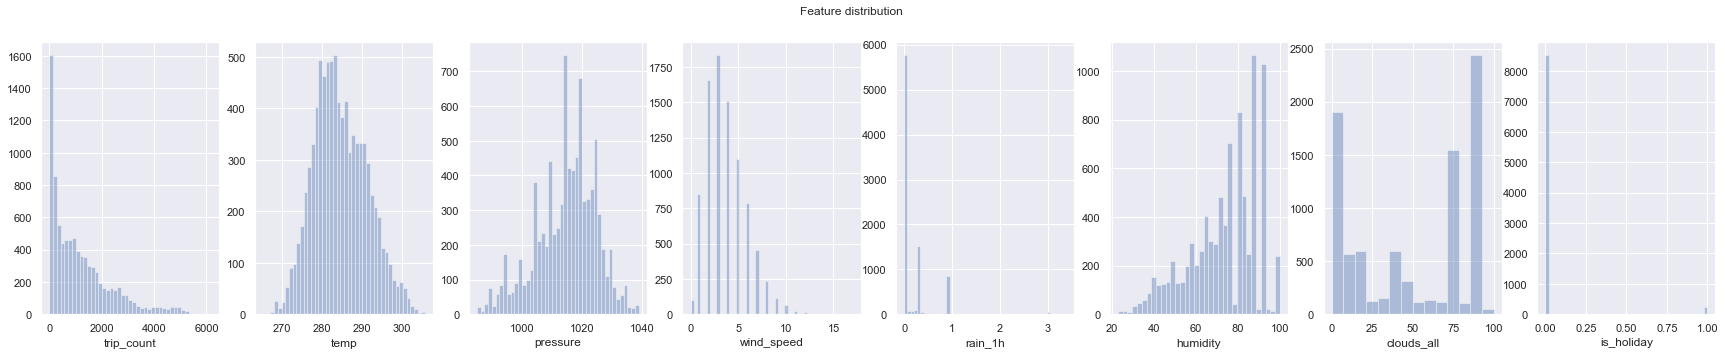

In [26]:
def plot_distribution(london,columns,**kwargs ):
    """
    Function to plot a dataframe feature distribution.
    Input: 
    df - pandas DataFrame.
    columns - list of the df columns that should be plotted
    Output: multiple feature histograms
    
    Note: String columns should be dropped before passing to the function.
    """
    #assert_is_not_none(london)
    #assert_is_instance(london, pd.DataFrame)
    
    fig, axes = plt.subplots(ncols=len(columns),figsize=(30,5))
    for axs, col in zip(axes, columns):
        sns.distplot(london[col], ax=axs,**kwargs)
    fig.suptitle('Feature distribution')
    
plot_distribution(df_london,df_london.drop(['timestamp','is_weekend','Clouds', 'Rain', 'Drizzle', 'Mist', 'Haze', 'Clear',
                                            'Fog', 'Snow', 'Thunderstorm', 'Smoke',],axis=1).columns, kde=False)

In [27]:
df_london['trip_log'] = np.log1p(df_london['trip_count'])

In [28]:
df_london.head()

,timestamp,trip_count,temp,pressure,wind_speed,rain_1h,humidity,clouds_all,Clear,Clouds,...,Fog,Haze,Mist,Rain,Smoke,Snow,Thunderstorm,is_weekend,is_holiday,trip_log
0,2018-01-01,754,280.27,996,9,0.0,70,68,0,1,...,0,0,0,0,0,0,0,0,1,6.626718
1,2018-01-02,90,279.16,1009,4,0.0,75,48,0,1,...,0,0,0,0,0,0,0,0,0,4.510860
2,2018-01-03,70,285.27,988,11,3.0,76,92,0,0,...,0,0,0,1,0,0,0,0,0,4.262680
3,2018-01-04,121,280.77,1001,6,0.0,75,40,0,1,...,0,0,0,0,0,0,0,0,0,4.804021
4,2018-01-05,94,278.85,993,3,0.3,81,92,0,0,...,0,0,0,1,0,0,0,0,0,4.553877


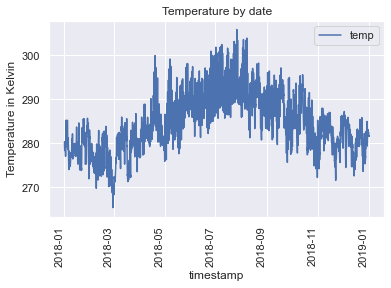

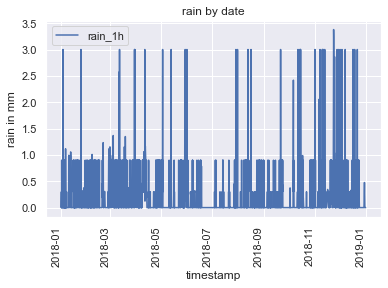

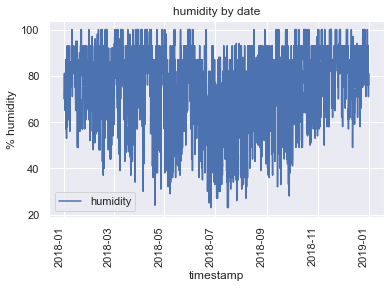

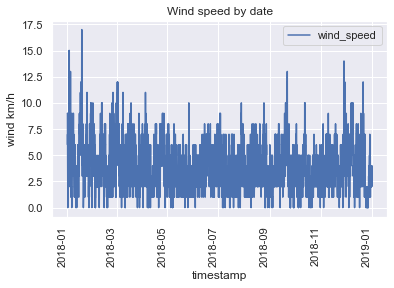

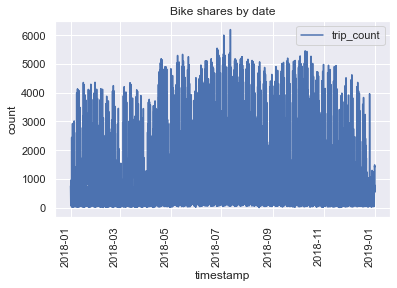

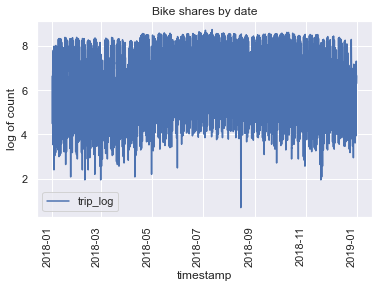

In [29]:
def plot_by_time(london,column,main_title,yaxis):
    """
    Plot values by timestamp.
    Input:
    london - pandas DataFrame
    column - name of the column to plot
    main_title - string for title of the plot
    yaxis -string for yaxis label
    
    """
    #assert_true(column in set(london.columns))
    
    
    ax = london.plot(x='timestamp',y=column, rot=90)
    plt.title(main_title)
    plt.ylabel(yaxis)
    plt.show()

#ax.set_xticklabels(pd.to_datetime(london.timestamp), rotation=90)
plot_by_time(df_london,'temp','Temperature by date','Temperature in Kelvin')
plot_by_time(df_london,'rain_1h','rain by date','rain in mm')
plot_by_time(df_london,'humidity','humidity by date','% humidity')
plot_by_time(df_london,'wind_speed','Wind speed by date','wind km/h')
plot_by_time(df_london,'trip_count','Bike shares by date','count')
plot_by_time(df_london,'trip_log','Bike shares by date','log of count')

In [30]:
#this pairs are highly correlated to each other so we will just take one--->temp
corr_matrix = df_london.corr().abs()
high_corr_var=np.where(corr_matrix>0.8)
high_corr_var=[(corr_matrix.columns[x],corr_matrix.columns[y]) for x,y in zip(*high_corr_var) if x!=y and x<y]
print(high_corr_var)

[('trip_count', 'trip_log')]


In [31]:
#df_london.corr()

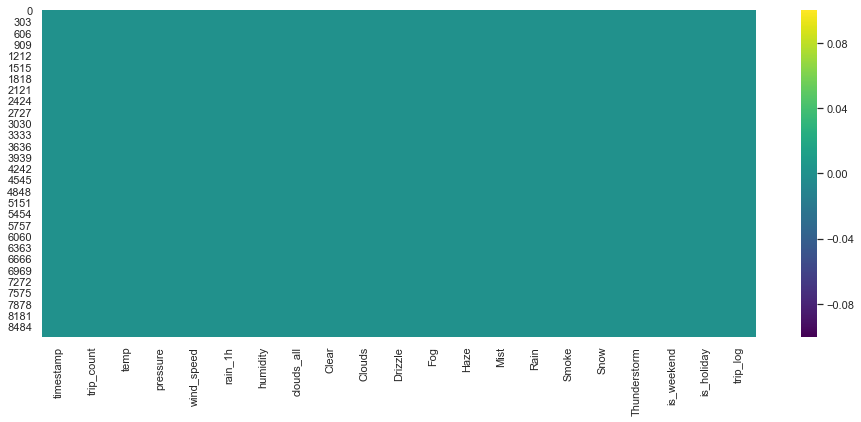

In [32]:
#This clean heatmap says that data does not have even a single Null value.
plt.figure(figsize=(16,6))
df_london.isnull().sum()
sns.heatmap(df_london.isnull(),cmap="viridis")

### Weekday vs Weekend

[Text(0, 0.5, 'average number of trips')]

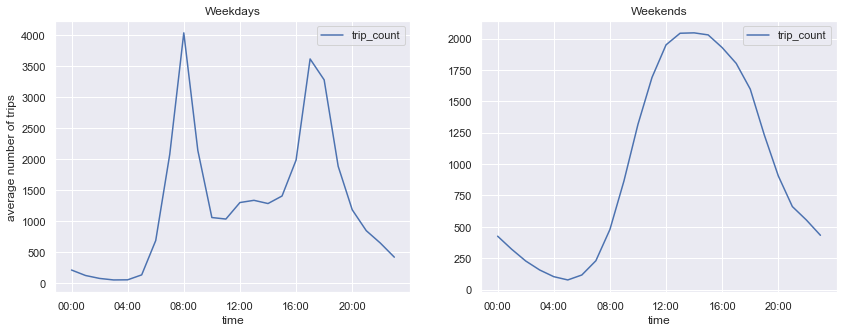

In [33]:
data=df_london[['trip_count','timestamp']]
data = data.set_index('timestamp')
hourly_ticks = 4 * 60 * 60 * np.arange(6)
weekend = np.where(data.index.weekday < 5, 'Weekday', 'Weekend')
by_time = data.groupby([weekend, data.index.time]).mean()
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
by_time.loc['Weekday'].plot(ax=ax[0], title='Weekdays',
                           xticks=hourly_ticks)
by_time.loc['Weekend'].plot(ax=ax[1], title='Weekends',
                           xticks=hourly_ticks);

ax[0].set(ylabel="average number of trips")

### humidity

Text(0, 0.5, 'humidity')

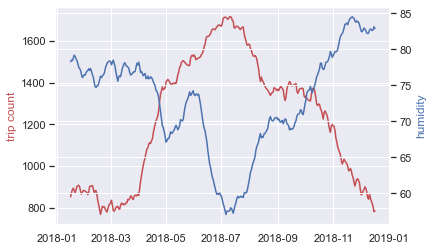

In [34]:
data=df_london[['trip_count','timestamp']]
data = data.set_index('timestamp')
hourly_trip = data.resample('D').mean()
hourly_trip=hourly_trip.rolling(30, center=True).mean()

data=df_london[['humidity','timestamp']]
data = data.set_index('timestamp')
hourly_rain = data.resample('D').mean()
#hourly_temp=hourly_temp.groupby(hourly_temp.index.time).mean()
hourly_rain=hourly_rain.rolling(30, center=True).mean()
#weekly.plot(style=[':', '--'])


fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(hourly_trip, 'r-')
ax2.plot(hourly_rain, 'b-')

ax1.set_ylabel('trip count', color='r')
ax2.set_ylabel('humidity', color='b')

### Rain

Text(0, 0.5, 'rain(mm)')

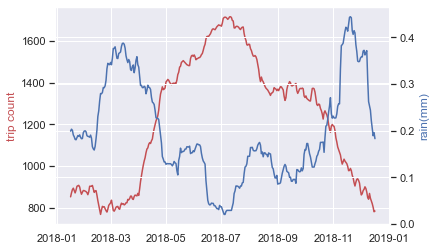

In [35]:
data=df_london[['trip_count','timestamp']]
data = data.set_index('timestamp')
hourly_trip = data.resample('D').mean()
#hourly_trip=hourly_trip.groupby(hourly_trip.index.time).mean()

hourly_trip=hourly_trip.rolling(30, center=True).mean()
data=df_london[['rain_1h','timestamp']]
data = data.set_index('timestamp')
hourly_rain = data.resample('D').mean()
#hourly_temp=hourly_temp.groupby(hourly_temp.index.time).mean()
hourly_rain=hourly_rain.rolling(30, center=True).mean()
#weekly.plot(style=[':', '--'])


fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(hourly_trip, 'r-')
ax2.plot(hourly_rain, 'b-')

ax1.set_ylabel('trip count', color='r')
ax2.set_ylabel('rain(mm)', color='b')

### Temprature

Text(0, 0.5, 'temp (kelvin)')

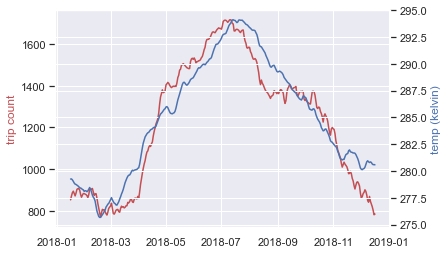

In [36]:
data=df_london[['trip_count','timestamp']]
data = data.set_index('timestamp')
daily_trip = data.resample('D').mean()
daily_trip=daily_trip.rolling(30, center=True).mean()
data=df_london[['temp','timestamp']]
data = data.set_index('timestamp')
daily_temp = data.resample('D').mean()
daily_temp=daily_temp.rolling(30, center=True).mean()
#weekly.plot(style=[':', '--'])


fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(daily_trip, 'r-')
ax2.plot(daily_temp, 'b-')

ax1.set_ylabel('trip count', color='r')
ax2.set_ylabel('temp (kelvin)', color='b')

In [37]:
def add_non_workday(df):
    """
    The function is grouping "is_holiday" and "is_weekend" columns into a new one "is_non_workday"
    Input: pandas DataFrame that contains columns 'is_holiday','is_weekend'
    """
#     assert_true('is_holiday' in set(df.columns))
#     assert_true('is_weekend' in set(df.columns))
    
    df['is_non_workday'] = df['is_holiday'] + df['is_weekend']
    df = df.drop(['is_holiday','is_weekend'],axis=1)
    
#     assert_true('is_non_workday' in set(df.columns))
    
    return df
df_london=add_non_workday(df_london)

In [38]:
df_london[df_london['trip_log']<6].groupby(by='is_non_workday').count()

,timestamp,trip_count,temp,pressure,wind_speed,rain_1h,humidity,clouds_all,Clear,Clouds,Drizzle,Fog,Haze,Mist,Rain,Smoke,Snow,Thunderstorm,trip_log
is_non_workday,,,,,,,,,,,,,,,,,,,
0,1768,1768,1768,1768,1768,1768,1768,1768,1768,1768,1768,1768,1768,1768,1768,1768,1768,1768,1768
1,1143,1143,1143,1143,1143,1143,1143,1143,1143,1143,1143,1143,1143,1143,1143,1143,1143,1143,1143


In [39]:
def add_hour(df):
    """
    The function is extracting the hour of a timestamp into a new column.
    Input: pandas DataFrame that contains 'timestamp' column
    """
#     assert_true('timestamp' in set(df.columns))
    
    df['hour'] = df['timestamp'].dt.hour
    
#     assert_true('hour' in set(df.columns))
    return df

df_london=add_hour(df_london)

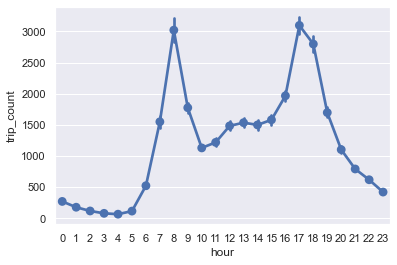

In [40]:
sns.pointplot(data=df_london, x='hour', y='trip_count')

In [41]:
df_london['is_rushhour']=0
df_london.loc[(df_london['hour'].isin([7,8,17,18]))& (df_london['is_non_workday']==0),'is_rushhour']=1


In [42]:
# def is_rushhour(df):
#     df['is_rushhour']=0
#     df.loc[(df['hour'].isin([8,17,18]))& (df['is_non_workday']==0),'is_rushhour']=1
# df_london=is_rushhour(df_london)

In [43]:
def add_night_hours(df):
    """
    The function is creating a new column "is_night". It requires a column with hours.
    If the hour is from 8:00 to 20:00 the data is classified as 0, if not in this interval it's 1.
    The purpose is try to to catch the sunlight status, but it's not taking in acount the time of the year and summertime.
    
    Input:
    df- pandas DataFrame, containing 'hour' column
    Output :
    Pandas DataFrame with added "is_night column"
    """
    #assert_true('hour' in set(df.columns))
    
    df['is_day'] = 1
    df.loc[(df['hour'] < 6) | (df['hour'] > 20), 'is_day'] = 0
    
    #assert_true('is_night' in set(df.columns))
    return df

df_london=add_night_hours(df_london)

In [44]:
from scipy.stats import norm, skew, kurtosis

def sns_hist(data,title):
    """"
    Function to plot seaborn histogram.
    """
    #assert_is_not_none(data)
    
    sns.distplot(data, fit=norm)
    plt.title(title)
    plt.ylabel('Density')

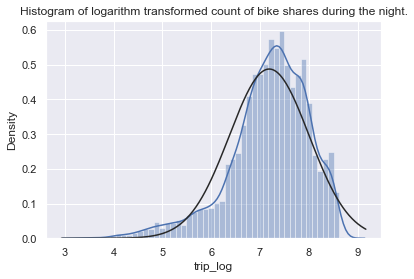

In [45]:
sns_hist(df_london[df_london['is_day']==1]['trip_log'],"Histogram of logarithm transformed count of bike shares during the night.")

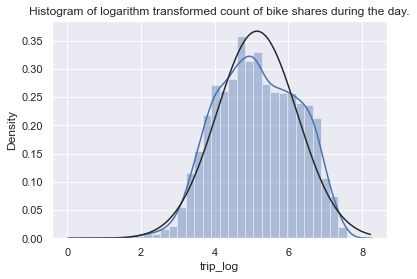

In [46]:
sns_hist(df_london[df_london['is_day']==0]['trip_log'],"Histogram of logarithm transformed count of bike shares during the day.")

In [47]:
#The conclusion from the graphics above is that when the data is 
#separated by day/night the distributions of transformed data looks more Gaussian.
#The next step is to implement machine learning algorithms.

In [48]:
from nose.tools import *
import statsmodels.api as sm
from scipy import stats
from scipy.stats import norm, skew, kurtosis

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV,cross_val_score 
from sklearn import preprocessing
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, AdaBoostRegressor
from xgboost.sklearn import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_absolute_error,r2_score, mean_squared_log_error,mean_squared_error, make_scorer

/home/tara/anaconda3/lib/python3.7/site-packages/dask/dataframe/utils.py:13: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [49]:
df_london.head()

,timestamp,trip_count,temp,pressure,wind_speed,rain_1h,humidity,clouds_all,Clear,Clouds,...,Mist,Rain,Smoke,Snow,Thunderstorm,trip_log,is_non_workday,hour,is_rushhour,is_day
0,2018-01-01,754,280.27,996,9,0.0,70,68,0,1,...,0,0,0,0,0,6.626718,1,0,0,0
1,2018-01-02,90,279.16,1009,4,0.0,75,48,0,1,...,0,0,0,0,0,4.510860,0,0,0,0
2,2018-01-03,70,285.27,988,11,3.0,76,92,0,0,...,0,1,0,0,0,4.262680,0,0,0,0
3,2018-01-04,121,280.77,1001,6,0.0,75,40,0,1,...,0,0,0,0,0,4.804021,0,0,0,0
4,2018-01-05,94,278.85,993,3,0.3,81,92,0,0,...,0,1,0,0,0,4.553877,0,0,0,0


In [50]:
#df_london=df_london.drop('hour',axis=1)

In [51]:
df_london.columns

Index(['timestamp', 'trip_count', 'temp', 'pressure', 'wind_speed', 'rain_1h',
       'humidity', 'clouds_all', 'Clear', 'Clouds', 'Drizzle', 'Fog', 'Haze',
       'Mist', 'Rain', 'Smoke', 'Snow', 'Thunderstorm', 'trip_log',
       'is_non_workday', 'hour', 'is_rushhour', 'is_day'],
      dtype='object')

In [52]:
# def add_bad_weather(df):
#     """
    
#     """
#     #assert_true('hour' in set(df.columns))
    
#     df['bad_weather'] = 1
#     df.loc[(df['wind_speed'] > 1) & (df['temp'] < 275) & (df['is_rushhour']==0), 'bad_weather'] = 0
#     df.loc[(df['rain_1h'] > 1) & (df['temp'] < 275) & (df['is_rushhour']==0), 'bad_weather'] = 0
#     df.loc[(df['humidity']>80)&(df['temp'] < 280)&(df['is_rushhour']==0), 'bad_weather'] = 0
#     #df.loc[(df['rain_1h']>3), 'bad_weather'] = 1
    
#     #assert_true('is_night' in set(df.columns))
#     return df

# df_london=add_bad_weather(df_london)

In [53]:
len(df_london[df_london.Snow==1])

164

In [54]:
len(df_london[df_london.Thunderstorm==1])

54

In [55]:
len(df_london[df_london.Smoke==1])

1

In [56]:
df_london=df_london.drop(['Smoke','Thunderstorm','Snow'],axis=1)

In [57]:
#len(df_london[df_london.bad_weather==0])

In [58]:
df_london.corr()

,trip_count,temp,pressure,wind_speed,rain_1h,humidity,clouds_all,Clear,Clouds,Drizzle,Fog,Haze,Mist,Rain,trip_log,is_non_workday,hour,is_rushhour,is_day
trip_count,1.000000,0.443242,0.120286,0.109876,-0.118010,-0.469376,-0.140071,0.112306,0.116999,-0.096869,-0.084265,-0.057983,-0.160877,-0.120298,0.834260,-0.136234,0.319544,0.660411,0.593868
temp,0.443242,1.000000,0.150902,0.037399,-0.162130,-0.562157,-0.190530,0.189141,0.142084,-0.115246,-0.151827,-0.111711,-0.226002,-0.137815,0.433087,-0.015019,0.184331,0.017249,0.200419
pressure,0.120286,0.150902,1.000000,-0.322223,-0.374200,-0.207539,-0.299478,0.296113,0.097157,-0.211643,0.019302,-0.021207,-0.094560,-0.435380,0.103876,0.022964,-0.001751,-0.012142,-0.009684
wind_speed,0.109876,0.037399,-0.322223,1.000000,0.096952,-0.213732,0.133847,-0.098483,0.110415,0.025352,-0.219635,-0.158343,-0.200176,0.158661,0.144847,-0.054162,0.160925,0.028854,0.185181
rain_1h,-0.118010,-0.162130,-0.374200,0.096952,1.000000,0.292276,0.324773,-0.254516,-0.370578,0.286816,0.141563,0.156858,0.245355,0.543866,-0.096248,0.021907,0.024767,0.010481,0.043044
humidity,-0.469376,-0.562157,-0.207539,-0.213732,0.292276,1.000000,0.352914,-0.314741,-0.272248,0.318008,0.325617,0.256625,0.457421,0.265346,-0.473751,0.050884,-0.293173,-0.034799,-0.305460
clouds_all,-0.140071,-0.190530,-0.299478,0.133847,0.324773,0.352914,1.000000,-0.684391,0.146661,0.320824,0.089523,0.142551,0.254164,0.363621,-0.121767,0.003823,-0.016266,0.009475,0.020954
Clear,0.112306,0.189141,0.296113,-0.098483,-0.254516,-0.314741,-0.684391,1.000000,-0.379247,-0.180938,-0.150880,-0.175689,-0.237299,-0.300332,0.100897,-0.006190,0.042360,-0.027855,-0.011287
Clouds,0.116999,0.142084,0.097157,0.110415,-0.370578,-0.272248,0.146661,-0.379247,1.000000,-0.263448,-0.219683,-0.255805,-0.345511,-0.437288,0.128856,-0.034979,0.068262,-0.000877,0.045950
Drizzle,-0.096869,-0.115246,-0.211643,0.025352,0.286816,0.318008,0.320824,-0.180938,-0.263448,1.000000,0.128528,0.112345,0.348130,0.337073,-0.080297,0.021605,-0.010222,0.016951,0.025969


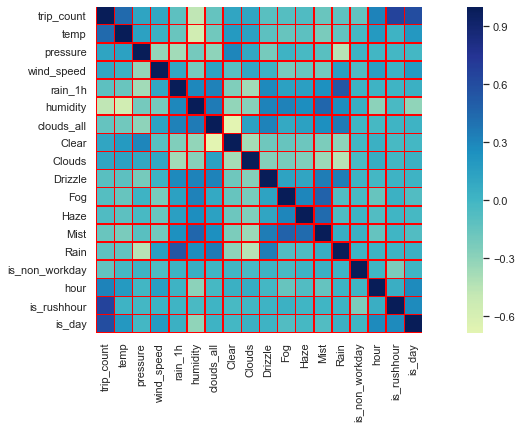

In [59]:
plt.figure(figsize=(16,6))
sns.heatmap(df_london.drop(['trip_log'],axis=1).corr(),cmap="YlGnBu",square=True,linewidths=.5,center=0,linecolor="red")

## Select 3 month data

In [60]:
df_london=df_london[(df_london['timestamp'].apply(lambda x: x.month==3))|(df_london['timestamp'].apply(lambda x: x.month==7))|(df_london['timestamp'].apply(lambda x: x.month==10))]

## Normalizing the features

In [60]:
london_df = df_london.drop(['timestamp','trip_count'],axis=1)
X = london_df.drop(['trip_log'], axis=1)
y = london_df['trip_log']
scaler_x = preprocessing.MinMaxScaler()
X =  pd.DataFrame(scaler_x.fit_transform(X), columns = X.columns)

/home/tara/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [61]:
X

,temp,pressure,wind_speed,rain_1h,humidity,clouds_all,Clear,Clouds,Drizzle,Fog,Haze,Mist,Rain,is_non_workday,hour,is_rushhour,is_day
0,0.367698,0.203704,0.529412,0.000000,0.610390,0.68,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.340282,0.444444,0.235294,0.000000,0.675325,0.48,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.491195,0.055556,0.647059,0.888003,0.688312,0.92,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.380048,0.296296,0.352941,0.000000,0.675325,0.40,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.332625,0.148148,0.176471,0.088800,0.753247,0.92,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8754,0.606293,0.574074,0.176471,0.121097,0.909091,0.90,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
8755,0.591968,0.629630,0.235294,0.000000,0.584416,0.08,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
8756,0.524786,0.740741,0.117647,0.000000,0.519481,0.00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
8757,0.422284,0.370370,0.176471,0.088800,0.831169,0.75,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [63]:
def rmse(y, y_pred):
    """
    Root squared logarithmic loss function.
    The function is trimming the negative values and replace them with 0. After that calculates the rmse.
    Input:
    y - true values
    y_pred - predicted values

    Output: rmse
    """
#     assert(y.shape == y_pred.shape)
#     y = np.expm1(y)
#     y_pred=y_pred.clip(min=0)
#     y_pred=y_pred.clip(max=10)
#     y_pred = np.expm1(y_pred)
#     return np.sqrt(mean_squared_log_error( y, y_pred))
    return sqrt(mean_squared_error(y, y_pred))


rmse_scorer = make_scorer(rmse, greater_is_better=False)
tscv = TimeSeriesSplit(n_splits=5)

In [64]:
import xgboost as xgb
xgbr = xgb.XGBRegressor(objective ='reg:squarederror',random_state=42) 
xgbr.fit(X_train, y_train)
y_pred = xgbr.predict(X_test)
error=(y_test-y_pred).values

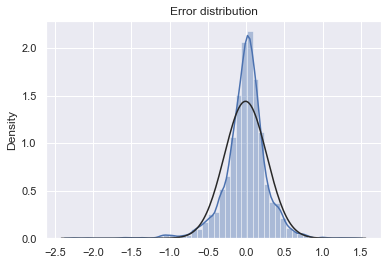

In [65]:
sns_hist(error,'Error distribution')

In [66]:
# london_df = df_london.drop(['timestamp','trip_log','weather_description'],axis=1)
# X = london_df.drop(['trip_count'], axis=1)
# y = london_df['trip_count']
# scaler_x = preprocessing.MinMaxScaler()
# X =  pd.DataFrame(scaler_x.fit_transform(X), columns = X.columns)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
# import xgboost as xgb
# xgbr = xgb.XGBRegressor(objective ='reg:squarederror',random_state=42) 
# xgbr.fit(X_train, y_train)

# y_pred = xgbr.predict(X_test)
# mse = mean_squared_error(y_test, y_pred)
# error=(y_test-y_pred).values
# sns_hist(error,'Error distribution')
# import statistics
# print(statistics.stdev(error))
# print(statistics.mean(error))

In [67]:
def test_algorithms():
    
    """
    A custom function designed for cross validation score on "london bike sharing dataset".
    The function is comparing the following algorithms :
    "LinearRegression", "Random Forrest", "XGBoost", "SVR" , "AdaBoost","BaggingRegressor",
    on "London bicycle sharing dataset" with mean rmse error, standard deviation on rmse and execution time. 
    The output of this function is a pandas dataframe.
    """
    names = ["LinearRegression", "Random Forrest", "XGBoost" , "AdaBoost",
             "BaggingRegressor"]
    
    regressors = [
        LinearRegression(),
        RandomForestRegressor(random_state=42),
        XGBRegressor(objective ='reg:squarederror',random_state=42),
       
        AdaBoostRegressor(random_state=42),
        BaggingRegressor(random_state=42)    
        ]
    
    #data_X = [X_dummies,X_train ,X_train ,X_dummies ,X_train ,X_train ]
    reg_columns=['algorithm','score_rmse_mean','score_std','time']
    reg_performance = pd.DataFrame(columns=reg_columns)
    print('Please wait 1-2 minutes for all algorithms to complete.')
    for name, regressor in zip(names, regressors):
        time_start = time.time()
        cv_results = cross_val_score(regressor, X_train,y_train, cv=5 ,scoring = rmse_scorer)
        time_end = round(time.time() - time_start,3)
        mean_score = round(-cv_results.mean(),4)
        std_score = round(cv_results.std(),4)
        t= pd.DataFrame([[name,mean_score,std_score,time_end]],columns = reg_columns)
        reg_performance = reg_performance.append(t, ignore_index=True)
        print(name , ' rmse = ',mean_score , 'with std=',std_score ," execution_time =  ", time_end,"s")
    return reg_performance
reg_performance = test_algorithms()
reg_performance


Please wait 1-2 minutes for all algorithms to complete.
LinearRegression  rmse =  0.6126 with std= 0.0137  execution_time =   0.054 s


/home/tara/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/tara/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/tara/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/tara/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/tara/anaconda3/lib/python3.7/site-packages/skl

Random Forrest  rmse =  0.3185 with std= 0.0087  execution_time =   0.875 s
XGBoost  rmse =  0.2861 with std= 0.0119  execution_time =   115.916 s
AdaBoost  rmse =  0.5643 with std= 0.0036  execution_time =   1.457 s
BaggingRegressor  rmse =  0.3187 with std= 0.0096  execution_time =   0.836 s


,algorithm,score_rmse_mean,score_std,time
0,LinearRegression,0.6126,0.0137,0.054
1,Random Forrest,0.3185,0.0087,0.875
2,XGBoost,0.2861,0.0119,115.916
3,AdaBoost,0.5643,0.0036,1.457
4,BaggingRegressor,0.3187,0.0096,0.836


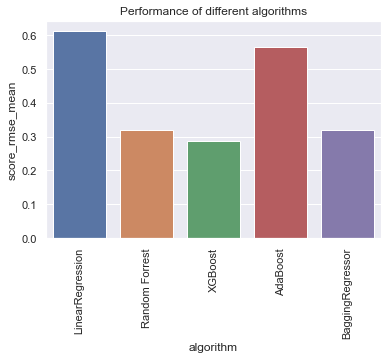

In [68]:
def plot_performance(df,x,y):
    """
    Function to bar plot algorithm performance.
    Inputs
    -------
    - df: DataFrame generated by test_algorithms() function
    - x: x column name, usually 'algorithm'
    - y: y column name - 'score_rmse_mean' or 'time'
    
    Returns
    -------
    Barplot of the performance
    """
    assert_is_not_none(df)
    assert_true(x in set(df.columns))
    assert_true(y in set(df.columns))
    
    
    sns.barplot(data=df, x=x,y=y)
    plt.title('Performance of different algorithms')
    plt.xticks( rotation='vertical')


plot_performance(reg_performance, x='algorithm',y='score_rmse_mean')

In [89]:
# xgb_model=XGBRegressor(objective ='reg:squarederror',random_state=42,booster='gblinear')
# xgb_model.fit(X, y)
# print(xgb_model.coef_)


In [88]:
# X2 = sm.add_constant(X)
# est = sm.OLS(y, X2)
# est2 = est.fit()
# print(est2.summary())

In [ ]:
import utils


[0.01325212 0.00351054 0.00258675 0.00743463 0.03199185 0.00614308
 0.00198855 0.00254434 0.00406389 0.00221501 0.00419508 0.00385386
 0.01428277 0.06128671 0.37179905 0.43135467 0.03749701]


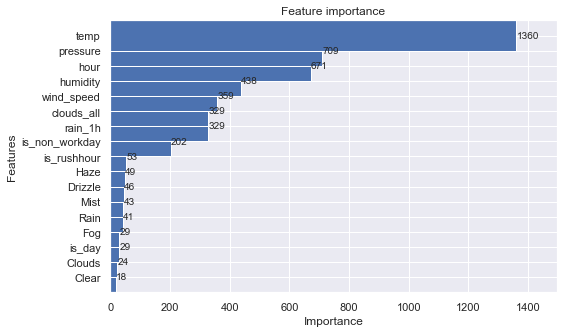

In [75]:
xgb_model=XGBRegressor(objective ='reg:squarederror',random_state=42)
xgb_model.fit(X, y)

# feature importance
print(xgb_model.feature_importances_)
# plot
fig ,ax =plt.subplots(figsize=(8,5))
plot_importance(xgb_model,height=2,xlabel='Importance',ax=ax)

pyplot.show()

In [71]:
from numpy import sort
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel
model=XGBRegressor(objective ='reg:squarederror')
model.fit(X_train, y_train)
# make predictions for test data and evaluate
predictions = model.predict(X_test)
# accuracy = accuracy_score(y_test, predictions)
# print("Accuracy: %.2f%%" % (accuracy * 100.0))
# Fit model using each importance as a threshold
thresholds = sort(model.feature_importances_)
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    # train model
    selection_model = XGBRegressor()
    selection_model.fit(select_X_train, y_train)
    
    # eval model
    select_X_test = selection.transform(X_test)
    predictions = selection_model.predict(select_X_test)
    rmse_score = rmse(y_test, predictions)
    
    print("Thresh=%.3f, n=%d, rmse: %.2f" % (thresh, select_X_train.shape[1], rmse_score ))
    feature_idx = selection.get_support()
    feature_name = X_train.columns[feature_idx]
    print(feature_name)

Thresh=0.001, n=17, rmse: 0.27
Index(['temp', 'pressure', 'wind_speed', 'rain_1h', 'humidity', 'clouds_all',
       'Clear', 'Clouds', 'Drizzle', 'Fog', 'Haze', 'Mist', 'Rain',
       'is_non_workday', 'hour', 'is_rushhour', 'is_day'],
      dtype='object')
Thresh=0.002, n=16, rmse: 0.27
Index(['temp', 'pressure', 'wind_speed', 'rain_1h', 'humidity', 'clouds_all',
       'Clear', 'Clouds', 'Drizzle', 'Haze', 'Mist', 'Rain', 'is_non_workday',
       'hour', 'is_rushhour', 'is_day'],
      dtype='object')
Thresh=0.003, n=15, rmse: 0.27
Index(['temp', 'wind_speed', 'rain_1h', 'humidity', 'clouds_all', 'Clear',
       'Clouds', 'Drizzle', 'Haze', 'Mist', 'Rain', 'is_non_workday', 'hour',
       'is_rushhour', 'is_day'],
      dtype='object')
Thresh=0.003, n=14, rmse: 0.28
Index(['temp', 'wind_speed', 'rain_1h', 'humidity', 'clouds_all', 'Clear',
       'Clouds', 'Drizzle', 'Mist', 'Rain', 'is_non_workday', 'hour',
       'is_rushhour', 'is_day'],
      dtype='object')
Thresh=0.003, n=13, r

In [109]:
#df_london.to_csv('exg_df.csv')

In [101]:
df_london.columns

Index(['timestamp', 'trip_count', 'temp', 'pressure', 'wind_speed', 'rain_1h',
       'humidity', 'clouds_all', 'Clear', 'Clouds', 'Drizzle', 'Fog', 'Haze',
       'Mist', 'Rain', 'trip_log', 'is_non_workday', 'hour', 'is_rushhour',
       'is_day'],
      dtype='object')